# Приветствие
Доброго времени суток!
Меня зовут Голубев Артём Алексеевич.
Ниже представлена работа по заключительному в рамках этого семестра домашнему заданию 5.
Приятного времяпровождения! :)


# Задание

## ВАМ НЕОБХОДИМО:
*	Ознакомьтесь с содержанием демонстрационных блокнотов.
*	Создайте новый блокнот, импортируйте необходимые библиотеки (необязательно копировать все — только нужные функции и /или классы).
*	Выполните следующие задания (каждое задание под отдельным заголовком #).
 
### ОПТИМИЗАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ
#### 1.  Для набора данных Cars Moldova
*	Предсказываем Price (используем уже чистый набор данных! с возможными новыми признаками).
*	Делаем предобработку с помощью Pipeline. Можем добавить полиномы от исходных числовых признаков, можем One-Hot Encoding.
*	Можем воспользоваться методом главных компонент PCA для числовых признаков.
*	Подбираем оптимальные гиперпараметры линейной регрессии (точнее для Регуляризации линейной регрессии) с использованием перекрестной проверки (можем «вручную» — просмотрев несколько вариантов, можем с помощью поиска по сетке / рандомизированного поиска).
*	Демонстрируем метрики, веса модели и т.п.
*	Смотрим на те случаи, когда модель ошибается, пытаемся анализировать.
 
### ОПТИМИЗАЦИЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ
#### 1.  Для набора данных Cars Moldova
*	Предсказываем Transmission (используем уже чистый набор данных! с возможными новыми признаками).
*	Делаем предобработку с помощью Pipeline. Можем добавить полиномы от исходных числовых признаков, можем One-Hot Encoding.
*	Можем воспользоваться методом главных компонент PCA для числовых признаков.
*	Подбираем оптимальные гиперпараметры логистической регрессии с использованием перекрестной проверки (можем «вручную» — просмотрев несколько вариантов, можем с помощью поиска по сетке / рандомизированного поиска).
*	Демонстрируем метрики, веса модели и т.п.
*	Смотрим на те случаи, когда модель ошибается, пытаемся анализировать.



# Импорты

## Общие

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## PCA

In [2]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics

## Линейная регрессия

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

## Логистическая регрессия

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import f1_score
import warnings 
warnings.simplefilter("ignore", UserWarning)

## Гиперпараметры

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
import scipy.stats as stats
from sklearn.utils.fixes import loguniform

## Pipeline

In [6]:
from sklearn.impute import SimpleImputer
from sklearn import preprocessing as prep 
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from joblib import dump, load
from sklearn.preprocessing import PolynomialFeatures

## Функции

In [7]:
def weights_vis(B, B0, features_names):
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]),rotation = 45 );

Немного модифицируем функцию визуализации:

In [8]:
def weights_vis_new(B, B0, features_names):
    numbers = np.arange(0,len(features_names)+1)
    Bs = np.hstack([B0,B])
    tick_labels = ['B'+str(num) for num in numbers]
    cc=['']*len(numbers)
    for n,val in enumerate(Bs):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'
    fig=plt.figure(figsize=(20,8))
    plt.bar(x = numbers, height = Bs, color = cc)
    plt.xticks(np.arange(0,len(features_names)+1),np.hstack(['b0', features_names]), rotation = 90, size= 6);

In [9]:
def print_stem(y, label, marker):
    markerline, stemlines, baseline = plt.stem(y, markerfmt=marker,label = label)
    markerline.set_markerfacecolor('none')

In [10]:
def calculate_f1_score(model_pipe, X, y):
    """Расчет коэффициента f1. 
    
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    """
    y_model = model_pipe.predict(X)
    return f1_score(y, y_model)

In [11]:
def calculate_f1_score(model_pipe, X, y):
    """Расчет коэффициента f1.    
    Параметры:
    ===========
    model_pipe: модель или pipeline
    X: признаки
    y: истинные значения
    """
    y_model = model_pipe.predict(X)
    return f1_score(y, y_model)

In [12]:
set_config(display="diagram") #чтобы была красивая визуализация

# 1. ОПТИМИЗАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ

## 1.1. Подбор гиперпараметров

Подберем параметры для L2-регуляризации.

Считаем датафрейм:

In [13]:
DF = pd.read_csv('content/cars_moldova_clean.csv', delimiter = ',')
DF = DF.drop('Year', axis=1)
DF

,Make,Model,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...
32069,Volkswagen,Passat,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32070,Land Rover,Freelander,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32071,Dacia,Logan Mcv,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32072,Mazda,6,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


Определим числовые и категориальные столбцы:

In [14]:
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\nlen = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\nlen = ',len(num_columns))

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
len =  5
numerical columns:	  ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age', 'km_year'] 
len =  5


Рассмотрим числовые столбцы. Проведем разбиение на тестовую и тренировочную выборки:

In [15]:
DF_num = DF[num_columns].copy()
X = DF_num.drop(columns = 'Price(euro)').values
y = DF_num['Price(euro)'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

Проведем рандомизированный поиск параметра альфа:

In [16]:
alpha_range = loguniform(1e-4, 1e4) 

tuned_parameters = [{'alpha':  alpha_range }]

n_iter_search = 25

Ridge_search = RandomizedSearchCV(estimator = Ridge(max_iter=10000 ), verbose = 3,
                          param_distributions=tuned_parameters ,
                          cv=ShuffleSplit(n_splits=5, random_state=42),n_iter = n_iter_search)

Ridge_search.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .........alpha=0.02202524268593486;, score=0.483 total time=   0.0s
[CV 2/5] END .........alpha=0.02202524268593486;, score=0.517 total time=   0.0s
[CV 3/5] END .........alpha=0.02202524268593486;, score=0.478 total time=   0.0s
[CV 4/5] END .........alpha=0.02202524268593486;, score=0.493 total time=   0.0s
[CV 5/5] END .........alpha=0.02202524268593486;, score=0.524 total time=   0.0s
[CV 1/5] END ........alpha=0.002347743458088189;, score=0.483 total time=   0.0s
[CV 2/5] END ........alpha=0.002347743458088189;, score=0.517 total time=   0.0s
[CV 3/5] END ........alpha=0.002347743458088189;, score=0.478 total time=   0.0s
[CV 4/5] END ........alpha=0.002347743458088189;, score=0.493 total time=   0.0s
[CV 5/5] END ........alpha=0.002347743458088189;, score=0.524 total time=   0.0s
[CV 1/5] END ........alpha=0.019491033225875077;, score=0.483 total time=   0.0s
[CV 2/5] END ........alpha=0.019491033225875077

RandomizedSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
                   estimator=Ridge(max_iter=10000), n_iter=25,
                   param_distributions=[{'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AE922282D0>}],
                   verbose=3)

In [17]:
Ridge_best=Ridge_search.best_estimator_
Ridge_best

Ridge(alpha=0.0001089136505486359, max_iter=10000)

In [18]:
DF_Ridge=pd.DataFrame(Ridge_search.cv_results_)
DF_ = DF_Ridge[['param_alpha',
             'mean_test_score', 'std_test_score', 'rank_test_score']]
cm = sns.light_palette("green", as_cmap=True)
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm)
hl

,param_alpha,mean_test_score,std_test_score,rank_test_score
10,0.000109,0.499038,0.018565,1
14,0.000140,0.499038,0.018565,2
23,0.000191,0.499038,0.018565,3
18,0.000395,0.499038,0.018565,4
22,0.000690,0.499038,0.018565,5
1,0.002348,0.499038,0.018565,6
24,0.003450,0.499038,0.018565,7
4,0.003816,0.499038,0.018565,8
16,0.005582,0.499038,0.018565,9
2,0.019491,0.499038,0.018565,10


Запомним лучшие значения.

## 1.2. Pipeline

Теперь загоним всё в пайплайн:

In [19]:
DF = pd.read_csv('content/cars_moldova_clean.csv', delimiter = ',')
DF = DF.drop('Year', axis=1)
DF

,Make,Model,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...
32069,Volkswagen,Passat,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32070,Land Rover,Freelander,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32071,Dacia,Logan Mcv,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32072,Mazda,6,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


In [20]:
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\nlen = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\nlen = ',len(num_columns))

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
len =  5
numerical columns:	  ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age', 'km_year'] 
len =  5


Подготовим данные и разобьем их на тестовую и тренировочную выборки:

In [21]:
data = DF.drop(columns = ['Price(euro)'])
target = DF['Price(euro)']
num_columns.remove('Price(euro)')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.3, random_state=42)

Создаем пайплайн для числовых значений: заполненяем пропуски медианным значением, нормализуем:

In [23]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])
numerical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())])

Создаем пайплайн для категориальных значений: заполнение пропусков наиболее частым значением, а категориальные переводим в One-hot:

In [24]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])
categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

Объединяем всё в один препроцессор:

In [25]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])
preprocessors

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)', 'Age',
                                  'km_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

Обучаем на тренировочной выборке:

In [26]:
preprocessors.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)', 'Age',
                                  'km_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type',
                                  'Transmission'])])

С помощью срезов вытащим в отдельную переменную названия категориальных данных после OHE трансформации:

In [27]:
cat_ohe_names = preprocessors.transformers_[1][1][1].get_feature_names_out(cat_columns)

Теперь преобразуем данные и объединим названия числовых и ohe-колонок в одну переменную. Посмотрим, какой получился датафрейм:

In [28]:
train_data = preprocessors.transform(X_train)
columns = np.append(num_columns, cat_ohe_names)
pd.DataFrame(train_data, columns=columns).head()

,Distance,Engine_capacity(cm3),Age,km_year,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,Make_Citroen,...,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid,Transmission_Manual
0,0.729946,0.416667,0.26,0.520470,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.633927,0.625000,0.44,0.274201,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.314463,0.270833,0.08,0.628457,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.301860,0.229167,0.28,0.199733,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.597920,0.250000,0.24,0.458918,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Аналогично действуем для валидационных данных:

In [29]:
val_data = preprocessors.transform(X_test)

Объединяем Pipeline предобработки и модель с заранее найденными параметрами:

In [30]:
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', Ridge(alpha = 0.000124, max_iter=10000))
])
pipe

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Age', 'km_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model', Ridge(alpha=0.000124, max_iter=10000))])

Обучаем через .fit():

In [31]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Age', 'km_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type',
                                                   'Transmission'])])),
                ('model', Ridge(alpha=0.000124, max_iter=10000))])

Смотрим метрики:

In [32]:
print('Train_score =', pipe.score(X_train, y_train))
print('Val_score =', pipe.score(X_test, y_test))

Train_score = 0.6362188751839102
Val_score = 0.6275144640589184


Метрики получились относительно неплохими. Точно значительно лучше, чем без использования OHE-столбцов.

Теперь рассмотрим значения весов. Для начала заведем их в отдельные переменные:

In [33]:
B = pipe[1].coef_
B0 = pipe[1].intercept_

Визуализируем веса:

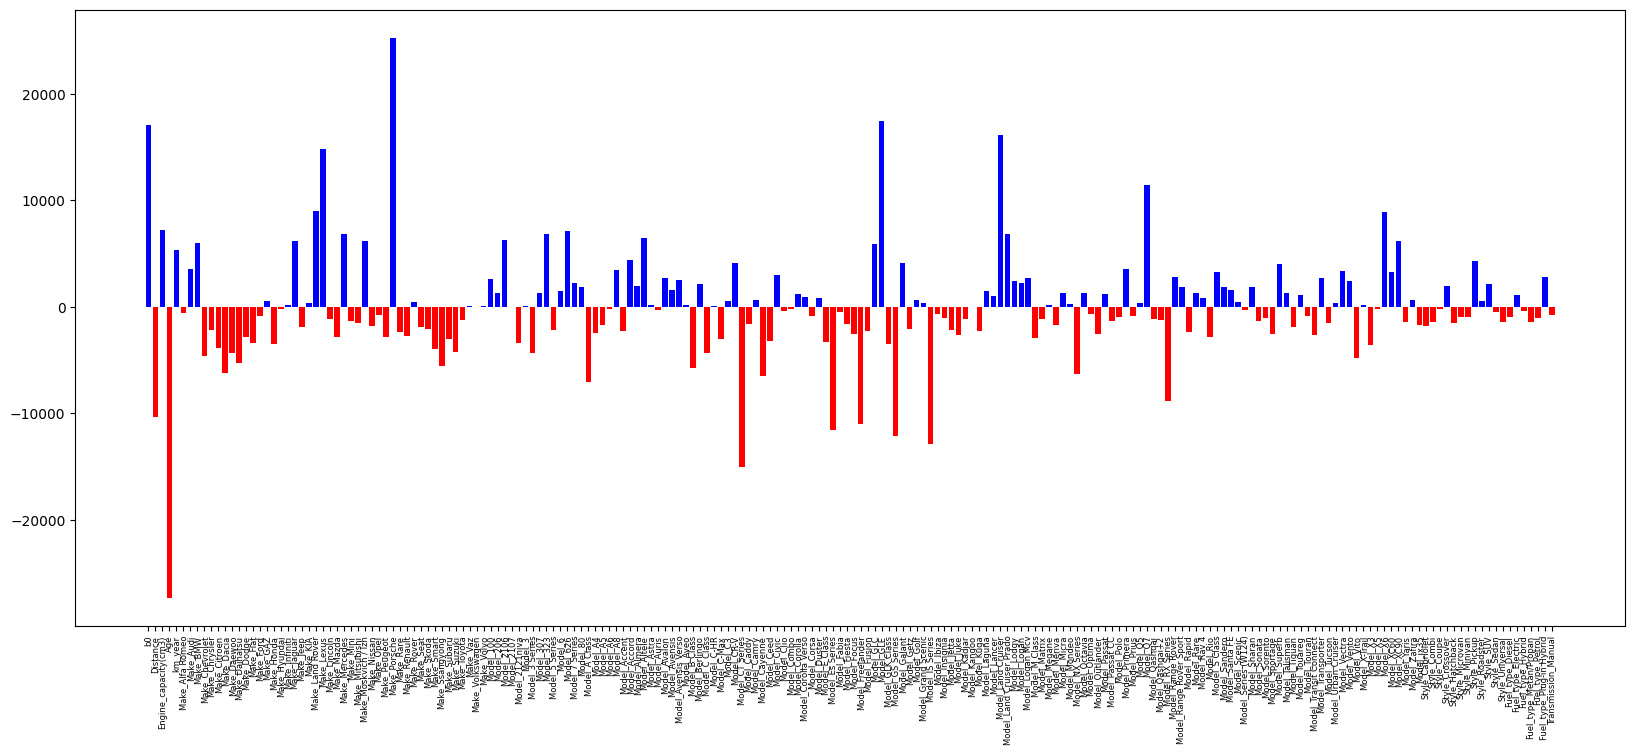

In [34]:
weights_vis_new(B, B0, columns)

Сохраним:

In [35]:
dump(pipe, 'LinReg_pipeline.joblib')

['LinReg_pipeline.joblib']

Рассмотрим предсказания модели на графике. Несмотря на некоторое улучшение модели с помощью OHE-кодирования, она всё ещё выдает очень много выбросов. Особенно обидно, когда эти выбросы "летят" в отрицательные значения, ибо отрицательная цена даже на подержаный автомобиль пока что является утопией:

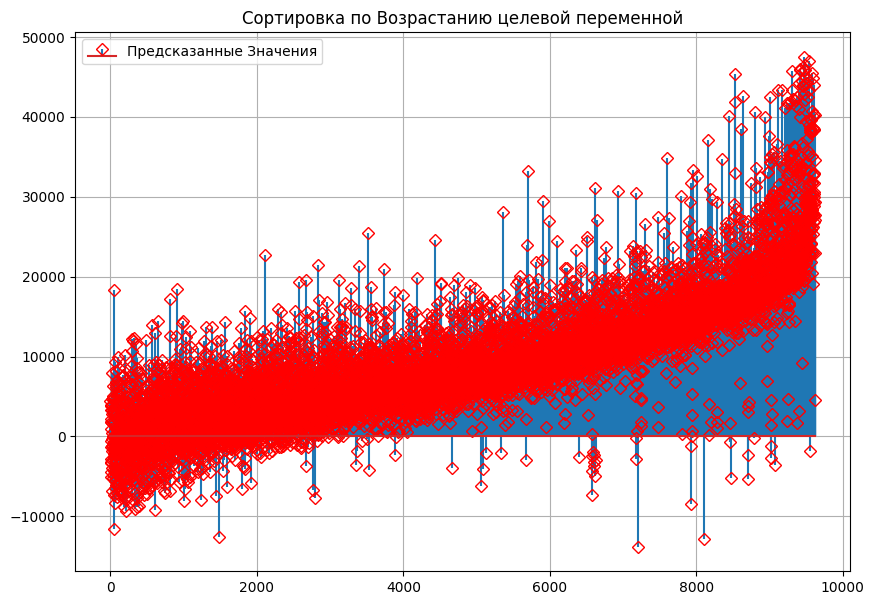

In [36]:
y_predict=pipe.predict(X_test)

fig=plt.figure(figsize=(10, 7))
sorted = np.argsort(y_test)
print_stem(y_predict[sorted], 'Предсказанные Значения', 'rD')

plt.grid()
plt.title('Сортировка по Возрастанию целевой переменной')
plt.legend();

## 1.3. Вывод.

OHE-преобразование позволило повысить R2 для линейной регрессии с 0.49 до 0.63, однако это всё ещё мало...

# 2. ОПТИМИЗАЦИЯ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ

## 2.1. Предподготовка данных

Подберем параметры для L1-регуляризации.

In [37]:
DF = pd.read_csv('content/cars_moldova_clean.csv', delimiter = ',')
DF = DF.drop('Year', axis=1)
DF

,Make,Model,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...
32069,Volkswagen,Passat,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32070,Land Rover,Freelander,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32071,Dacia,Logan Mcv,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32072,Mazda,6,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


In [38]:
cat_columns = []
num_columns = []

for column_name in DF.columns:
    if (DF[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('categorical columns:\t ',cat_columns, '\nlen = ',len(cat_columns))

print('numerical columns:\t ',  num_columns, '\nlen = ',len(num_columns))

categorical columns:	  ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission'] 
len =  5
numerical columns:	  ['Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'Age', 'km_year'] 
len =  5


In [39]:
data = DF.drop(columns = ['Transmission'])
target = DF['Transmission']
cat_columns.remove('Transmission')
cat_columns

['Make', 'Model', 'Style', 'Fuel_type']

Закодируем целевой столбец трансмиссии цифрами:

In [40]:
Label = prep.LabelEncoder()
Label.fit(target)              
Label_encoded = Label.transform(target)

In [41]:
Label.classes_

array(['Automatic', 'Manual'], dtype=object)

Разбиваем на тестовую и тренировочную выборки:

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data, Label_encoded, test_size = 0.3, random_state=42)

## 2.2. Pipeline

Теперь загоним всё в пайплайн:

Создаем пайплайн для числовых значений: заполненяем пропуски медианным значением, нормализуем:

In [43]:
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])
numerical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler())])

Создаем пайплайн для категориальных значений: заполнение пропусков наиболее частым значением, а категориальные переводим в One-hot:

In [44]:
categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent', )),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False))
])
categorical_pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder',
                 OneHotEncoder(drop='if_binary', handle_unknown='ignore',
                               sparse_output=False))])

Объединяем всё в один препроцессор:

In [45]:
preprocessors = ColumnTransformer(transformers=[
    ('num', numerical_pipe, num_columns),
    ('cat', categorical_pipe, cat_columns)
])
preprocessors

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)',
                                  'Price(euro)', 'Age', 'km_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type'])])

Обучаем на тренировочной выборке:

In [46]:
preprocessors.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['Distance', 'Engine_capacity(cm3)',
                                  'Price(euro)', 'Age', 'km_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type'])])

С помощью срезов вытащим в отдельную переменную названия категориальных данных после OHE трансформации:

In [47]:
cat_ohe_names = preprocessors.transformers_[1][1][1].get_feature_names_out(cat_columns)

Теперь преобразуем данные и объединим названия числовых и ohe-колонок в одну переменную. Посмотрим, какой получился датафрейм:

In [48]:
train_data = preprocessors.transform(X_train)
columns = np.append(num_columns, cat_ohe_names)
pd.DataFrame(train_data, columns=columns).head()

,Distance,Engine_capacity(cm3),Price(euro),Age,km_year,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,...,Style_Roadster,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,0.729946,0.416667,0.098196,0.26,0.520470,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.633927,0.625000,0.053106,0.44,0.274201,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.314463,0.270833,0.122144,0.08,0.628457,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.301860,0.229167,0.010521,0.28,0.199733,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.597920,0.250000,0.048066,0.24,0.458918,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


Аналогично действуем для валидационных данных:

In [49]:
val_data = preprocessors.transform(X_test)
pd.DataFrame(val_data, columns=columns).head()

,Distance,Engine_capacity(cm3),Price(euro),Age,km_year,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Chevrolet,Make_Chrysler,...,Style_Roadster,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,0.599920,0.541667,0.019038,0.54,0.212711,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.247568,0.372500,0.087675,0.16,0.273790,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.373875,0.270833,0.020040,0.28,0.247829,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.440094,0.250000,0.025050,0.30,0.273676,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.281856,0.479167,0.160822,0.16,0.311957,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Объединяем Pipeline предобработки и модель логистической регрессии:

In [50]:
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression(C=0.001, random_state=42))
])
pipe

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type'])])),
                ('model', LogisticRegression(C=0.001, random_state=42))])

Обучаем через .fit():

In [51]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type'])])),
                ('model', LogisticRegression(C=0.001, random_state=42))])

Смотрим метрики:

In [52]:
print(f"F1 на тренировочной выборке: {calculate_f1_score(pipe, X_train, y_train):.4f}")
print(f"F1 на тестовой выборке: {calculate_f1_score(pipe, X_test, y_test):.4f}")

F1 на тренировочной выборке: 0.8231
F1 на тестовой выборке: 0.8347


Всё довольно неплохо. Предсказание трансмисии работает хорошо.

Сохраним пайплайн в файл:

In [53]:
dump(pipe, 'LogReg_pipeline.joblib')

['LogReg_pipeline.joblib']

## 2.3. Гиперпараметры

Попробуем подобрать гиперпараметры:
* У метода главных компонет поварьеруем количество главных компонент
* У логистической регрессии константу регуляризации

Создаем Pipeline для числовых данных:

In [54]:
numerical_pipe_pca = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('PCA', PCA()),
])
numerical_pipe_pca

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', MinMaxScaler()), ('PCA', PCA())])

Объединяем пайплайны для числовых и категориальных данных:

In [55]:
preprocessors_pca = ColumnTransformer(transformers=[
    ('num', numerical_pipe_pca, num_columns),
    ('cat', categorical_pipe, cat_columns)
])
preprocessors_pca

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler()),
                                                 ('PCA', PCA())]),
                                 ['Distance', 'Engine_capacity(cm3)',
                                  'Price(euro)', 'Age', 'km_year']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Make', 'Model', 'Style', 'Fuel_type'])])

Объединяем пайплайн предварительной обработки и модель

In [56]:
pipe_gs = Pipeline([
    ('preprocessors', preprocessors_pca),
    ('model', LogisticRegression(random_state=42,
                                 max_iter = 10000,
                                 solver = 'liblinear'))
])
pipe_gs

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA())]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type'])])),
                ('model',
                 LogisticRegression(max_iter=10000, random_state=42,
                                    solver='liblinear'))])

Задаем словарь гиперпараметров, которые мы хотим проверить.

**ВАЖНО**:
* Используем "имена" которые есть у компонент Pipeline и разделяем их __ (две земли)
* Поскольку PCA у нас "спрятан" то нужно пройти глубоко, идем с конца
* Варьируем количество главных компонент от 1 до 5 (количество числовых признаков)

In [57]:
param_grid = {
    "preprocessors__num__PCA__n_components": np.arange(1,6),
    "model__C": np.logspace(-4, 4, 5),
}

Складываем всё аккуратно в GridSearch:

In [58]:
Pipe_GS = GridSearchCV(estimator = pipe_gs, # оптимизируем наш pipeline
                       param_grid=param_grid , # что оптимизируем - берем из словарика
                          cv=ShuffleSplit(n_splits=5, random_state=42), # указываем тип кросс-валидации
                       verbose = 2 # чтобы он всё подробно расписал. если не интересно - пишем 0
                       )
Pipe_GS

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=None, train_size=None),
             estimator=Pipeline(steps=[('preprocessors',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler()),
                                                                                         ('PCA',
                                                                                          PCA())]),
                                                                         ['Distance',
                                                                          'Engine_capacity(cm3)',
                                                                          'Price(euro)',
                                                                          'Age',
                                                                          'km_year']),
                                                                        ('cat',
                                                                         Pip...
                                                                                         ('encoder',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Make',
                                                                          'Model',
                                                                          'Style',
                                                                          'Fuel_type'])])),
                                       ('model',
                                        LogisticRegression(max_iter=10000,
                                                           random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'model__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]),
                         'preprocessors__num__PCA__n_components': array([1, 2, 3, 4, 5])},
             verbose=2)

Обучаем через .fit():

In [59]:
Pipe_GS.fit(X_train, y_train);

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=1; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=2; total time=   0.0s
[CV] END model__C=0.0001, preprocessors__num__PCA__n_components=3; total time=

Лучший кандидат:

In [60]:
Pipe_best=Pipe_GS.best_estimator_
Pipe_best

Pipeline(steps=[('preprocessors',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler()),
                                                                  ('PCA',
                                                                   PCA(n_components=4))]),
                                                  ['Distance',
                                                   'Engine_capacity(cm3)',
                                                   'Price(euro)', 'Age',
                                                   'km_year']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='if_binary',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Make', 'Model', 'Style',
                                                   'Fuel_type'])])),
                ('model',
                 LogisticRegression(C=10000.0, max_iter=10000, random_state=42,
                                    solver='liblinear'))])

Посмотрим на результаты:

In [61]:
DF_Pipe = pd.DataFrame(Pipe_GS.cv_results_)
DF_Pipe

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_preprocessors__num__PCA__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.116453,0.010647,0.012249,0.001747,0.0001,1,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.663847,0.663847,0.623330,0.647373,0.638468,0.647373,0.015493,25
1,0.119993,0.006614,0.011400,0.000500,0.0001,2,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.678094,0.694123,0.649599,0.666073,0.654052,0.668388,0.016251,24
2,0.122197,0.011978,0.013592,0.004804,0.0001,3,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.698130,0.710151,0.670971,0.688780,0.673197,0.688246,0.014851,21
3,0.104603,0.005451,0.011592,0.001211,0.0001,4,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.697685,0.710151,0.670971,0.688780,0.673642,0.688246,0.014703,22
4,0.114604,0.010021,0.011988,0.001412,0.0001,5,"{'model__C': 0.0001, 'preprocessors__num__PCA_...",0.697240,0.710151,0.670525,0.689225,0.673197,0.688068,0.014846,23
5,0.123743,0.002603,0.011964,0.000897,0.01,1,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.780053,0.799644,0.795637,0.796082,0.795637,0.793411,0.006846,20
6,0.123513,0.005004,0.010293,0.000561,0.01,2,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.809884,0.832591,0.821906,0.817898,0.816563,0.819768,0.007489,16
7,0.130807,0.004299,0.011454,0.001007,0.01,3,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.815672,0.832591,0.828139,0.827694,0.824132,0.825646,0.005664,14
8,0.126407,0.006565,0.011396,0.000493,0.01,4,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.815672,0.832591,0.828139,0.827694,0.824132,0.825646,0.005664,14
9,0.125402,0.006713,0.011604,0.001013,0.01,5,"{'model__C': 0.01, 'preprocessors__num__PCA__n...",0.816118,0.833037,0.828139,0.828584,0.825022,0.826180,0.005643,13


In [62]:
DF_Pipe.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_model__C', 'param_preprocessors__num__PCA__n_components',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

Визуализируем (добавим немножечко депрессии цветом, нам же этого так не хватает))):

In [63]:
DF_ = DF_Pipe[['param_model__C', 'param_preprocessors__num__PCA__n_components', 
             'mean_test_score', 
             'std_test_score', 
             'rank_test_score']]
cm = sns.light_palette("black", as_cmap=True) 
hl = DF_.sort_values(by = 'rank_test_score').style.background_gradient(cmap=cm) 
hl

,param_model__C,param_preprocessors__num__PCA__n_components,mean_test_score,std_test_score,rank_test_score
23,10000.000000,4,0.854230,0.002496,1
18,100.000000,4,0.853963,0.002627,2
19,100.000000,5,0.853517,0.002406,3
24,10000.000000,5,0.853428,0.002493,4
22,10000.000000,3,0.852805,0.003255,5
17,100.000000,3,0.852805,0.003409,5
13,1.000000,4,0.852360,0.002961,7
12,1.000000,3,0.851113,0.004220,8
14,1.000000,5,0.851024,0.002796,9
11,1.000000,2,0.839537,0.003479,10


**ВЫВОД:** Вспоминаем, что в логистической регрессии С = 1/alpha и понимаем, что регуляризацией нам лучше не мешать. Метод главных компонент тоже не очень полезен оказывается, нужно больше полезных признаков, чтобы избавиться от бесполезных.

Попробуем посмотреть на предсказания модели при использовании регуляризации с коэффициентом С=100. Видим приличное увеличение метрик на несколько процентных пунктов:

In [64]:
pipe = Pipeline([
    ('preprocessors', preprocessors),
    ('model', LogisticRegression(C=100, random_state=42))
])
pipe.fit(X_train, y_train)
print(f"F1 на тренировочной выборке: {calculate_f1_score(pipe, X_train, y_train):.4f}")
print(f"F1 на тестовой выборке: {calculate_f1_score(pipe, X_test, y_test):.4f}")

F1 на тренировочной выборке: 0.8720
F1 на тестовой выборке: 0.8734


In [65]:
dump(pipe, 'LogReg_pipeline.joblib')

['LogReg_pipeline.joblib']

# 3. Вывод

Пайплайн очень удобная штука, а для улучшения метрик лучше создавать побольше полезных признаков, а не убирать регуляризациями и без того малочисленные исходные.

На этом, пожалуй, всё.
До встречи в следующих эпизодах следующего семестра! =)